In [476]:
import collections
import itertools
import json
import pathlib
import pickle

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker
import ml_collections
import numpy as np
import pandas as pd
import torch

import hier
import hier_torch
import infer
import main
import metrics
import progmet
import tree_util

In [47]:
Experiment = collections.namedtuple('Experiment', ['root', 'pattern'])
Trial = collections.namedtuple('Trial', ['root', 'config_file', 'model_file'])

In [518]:
EXP_ROOT = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments')
PLOT_DIR = 'output/plots/inat21mini-res18-ep20-repeat/'
experiment_patterns = {
    'flat_softmax': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'flat_softmax-b64-lr0.01-wd0.0003-s*'),
    'hier_softmax': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'hier_softmax-b64-lr0.01-wd0.0003-s*'),
    'cond_multilabel': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'cond_multilabel-b64-lr0.01-wd0.0003-s*'),
    'descendant_softmax': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'descendant_softmax-b64-lr0.01-wd0.0003-s*'),
    'descendant_softmax_complement': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'descendant_softmax_complement-b64-lr0.01-wd0.0003-s*'),
    'soft_margin-incorrect-5': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'soft_margin-incorrect-5-b64-lr0.01-wd0.0003-s*'),
#     'multilabel_focal': Experiment(
#         EXP_ROOT / '', ''),
#     '': Experiment(
#         EXP_ROOT / '', ''),
}

method_titles = {
    'flat_softmax': 'Flat',
    'hier_softmax': 'Cond softmax',
    'cond_multilabel': 'Cond sigmoid',
    'descendant_softmax': 'Soft-max-descendant',
    'descendant_softmax_complement': 'Soft-max-descendant (cousin)',
    'soft_margin-incorrect-5': 'Soft-max-margin (correct)',
}

colors = dict(zip(
    experiment_patterns,
    map(matplotlib.cm.get_cmap('tab10'), itertools.count())))

In [283]:
trial_names = {
    experiment: sorted([
        path.name for path in pathlib.Path(EXP_ROOT).glob(experiment_patterns[experiment])
        if (path / 'checkpoints/epoch-0020.pth').exists()
    ]) for experiment in experiment_patterns
}

trials = {
    experiment: {
        trial_name: Trial(
            root=pathlib.Path(EXP_ROOT) / trial_name,
            config_file=pathlib.Path(EXP_ROOT) / trial_name / 'config.json',
            model_file=pathlib.Path(EXP_ROOT) / trial_name / 'checkpoints/epoch-0020.pth')
        for trial_name in trial_names[experiment]
    } for experiment in trial_names
}

In [284]:
device = torch.device('cuda')

In [285]:
import configs.inaturalist2021mini

base_config = configs.inaturalist2021mini.get_config()
base_config.dataset_root = '/home/jack/data/manual/inaturalist2021/'

_, eval_dataset, tree, _, _, eval_label_map = main.make_datasets(base_config)

In [286]:
eval_loader = torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=8)

In [287]:
is_leaf = tree.leaf_mask()
specificity = np.log2(tree.num_leaf_nodes()) - np.log2(tree.num_leaf_descendants())
not_trivial = (tree.num_children() != 1)
subtract_children_cpu = hier_torch.SubtractChildren(tree)
subtract_children_cuda = hier_torch.SubtractChildren(tree).cuda()

In [288]:
gt_nodes = np.arange(tree.num_nodes())[:, None]
pr_nodes = np.arange(tree.num_nodes())[None, :]

matrix_correct_recall = (
    metrics.correct(tree, gt_nodes, pr_nodes).astype(np.float32) *
    metrics.LCAMetric(tree, specificity.astype(np.float32)).recall(gt_nodes, pr_nodes)
)
# matrix_info_f1 = (
#     metrics.LCAMetric(tree, specificity.astype(np.float32)).f1(gt_nodes, pr_nodes))
# matrix_correct_info = (
#     metrics.correct(tree, gt_nodes, pr_nodes) * specificity[pr_nodes]
# )

matrix_correct_recall = torch.from_numpy(matrix_correct_recall).cuda()

In [504]:
infer_fns = {
    'leaf': lambda p: infer.argmax_where(p, is_leaf),
    'exclusive': lambda p: np.argmax(subtract_children_cpu(torch.from_numpy(p)).numpy(), axis=-1),
    'majority': lambda p: infer.argmax_with_confidence(specificity, p, 0.5, not_trivial),
    'plurality': lambda p: infer.argmax_where(
        specificity, not_trivial & (p > infer.plurality_threshold(tree, p, keepdims=True))),
    'expected': lambda p: infer.argmax_where(p * specificity, not_trivial),
    'crm_correct_recall': lambda p: (
        infer.argmax_where(
            torch.tensordot(
                subtract_children_cuda(torch.from_numpy(p).cuda()),
                matrix_correct_recall,
                1,
            ).cpu().numpy(),
            not_trivial)),
    # 'crm_info_f1': lambda p: infer.argmax_where(np.dot(p, matrix_info_f1), not_trivial),
    # 'crm_correct_info': lambda p: infer.argmax_where(np.dot(p, matrix_correct_info), not_trivial),
}

markers = {
    'leaf': 'o',
    'exclusive': 'x',
    'majority': '^',
    'plurality': '>',
    'expected': 'd',
    'crm_correct_recall': '+',
}

inference_titles = {
    'leaf': 'Leaf',
    'exclusive': 'Exclusive',
    'majority': 'Majority',
    'plurality': 'Plurality',
    'expected': 'Expected info',
    'crm_correct_recall': 'Cond risk (correct info)',
}

In [56]:
info_metric = metrics.UniformLeafInfoMetric(tree)
depth_metric = metrics.DepthMetric(tree)

metric_fns = {
    'exact': lambda gt, pr: pr == gt,
    'correct': metrics.IsCorrect(tree),
    'info_excess': info_metric.excess,
    'info_deficient': info_metric.deficient,
    'info_dist': info_metric.dist,
    'info_recall': info_metric.recall,
    'info_precision': info_metric.precision,
    'info_f1': info_metric.f1,
    'depth_excess': depth_metric.excess,
    'depth_deficient': depth_metric.deficient,
    'depth_dist': depth_metric.dist,
    'depth_recall': depth_metric.recall,
    'depth_precision': depth_metric.precision,
    'depth_f1': depth_metric.f1,
}

metric_titles = {
    'exact': 'Exact',
    'correct': 'Correct',
    'info_recall': 'Information Recall',
    'info_precision': 'Information Precision',
    'depth_recall': 'Depth Recall',
    'depth_precision': 'Depth Precision',
    'info_lca': 'LCA Information',
    'depth_lca': 'LCA Depth',
}

In [62]:
def apply_model(net, pred_fn, min_threshold, limit=None):
    # Per-example predictions.

    outputs = {
        'gt': [],  # Node in hierarchy.
        'pred': {method: [] for method in infer_fns},
    }
    # Sequence-per-example predictions. Cannot be concatenated due to ragged shape.
    seq_outputs = {
        'pred': [],
        'prob': [],
    }

    net.eval()
    with torch.inference_mode():
        meter = progmet.ProgressMeter('apply', interval_time=5)
        for minibatch in itertools.islice(meter(eval_loader), limit):
            inputs, gt_labels = minibatch
            theta = net(inputs.to(device))
            prob = pred_fn(theta).cpu().numpy()
            pred = {}
            for name, infer_fn in infer_fns.items():
                pred[name] = infer_fn(prob)
            gt_node = eval_label_map.to_node[gt_labels]
            pred_seqs = [
                infer.pareto_optimal_predictions(specificity, p, min_threshold, not_trivial)
                for p in prob
            ]
            prob_seqs = [prob[i, pred_i] for i, pred_i in enumerate(pred_seqs)]
            # Caution: Predictions are *not* truncated.

            outputs['gt'].append(gt_node)
            for method in infer_fns:
                outputs['pred'][method].append(pred[method])
            seq_outputs['pred'].extend(pred_seqs)
            seq_outputs['prob'].extend(prob_seqs)

    # Concatenate results from minibatches.
    leaf_predicate = lambda x: not isinstance(x, dict)  # Treat lists as values, not containers.
    outputs = tree_util.tree_map(np.concatenate, outputs, is_leaf=leaf_predicate)

    return outputs, seq_outputs

In [63]:
def assess_predictions(outputs, seq_outputs):
    gt = outputs['gt']
    pred = outputs['pred']
    pred_seq = seq_outputs['pred']
    prob_seq = seq_outputs['prob']

    # Evaluate predictions for each method.
    pred = {
        method: hier.truncate_at_lca(tree, gt, pr)
        for method, pr in pred.items()
    }
    pred_metrics = {
        method: {field: np.mean(metric_fn(gt, pr))
                 for field, metric_fn in metric_fns.items()}
        for method, pr in pred.items()
    }

    # Evaluate predictions in Pareto sequence.
    find_lca = hier.FindLCA(tree)
    specificity_seq = [specificity[pr_i] for pr_i in pred_seq]
    pred_seq = [hier.truncate_given_lca(gt_i, pr_i, find_lca(gt_i, pr_i)) for gt_i, pr_i in zip(gt, pred_seq)]
    metric_values_seq = {
        field: [metric_fn(gt_i, pr_i) for gt_i, pr_i in zip(gt, pred_seq)]
        for field, metric_fn in metric_fns.items()
    }
    pareto_scores, pareto_totals = metrics.operating_curve(prob_seq, metric_values_seq)
#     specificity_seq = [np.flip(seq) for seq in specificity_seq]
#     metric_values_seq = {field: np.flip(seq) for field, seq in metric_values_seq.items()}
#     pareto_scores, pareto_totals = metrics.operating_curve(specificity_seq, metric_values_seq)
    pareto_means = {k: v / len(gt) for k, v in pareto_totals.items()}

    return pred_metrics, pareto_scores, pareto_means

In [134]:
def resample_threshold(scores, metric, x):
    return metric[np.searchsorted(-scores, -x)]

In [64]:
# Initialize results if not defined.
try:
    results
except NameError:
    results = {}  # Not defined.

In [188]:
# results = {}

In [189]:
MIN_THRESHOLD = None  # Values less than 0.5 may increase runtime significantly.
LIMIT = None
IGNORE_CACHE_FILE = False

score_grid = np.flip(np.linspace(0, 1, 1001))

for experiment_name in trials:
    for trial_name, trial in trials[experiment_name].items():
        key = (experiment_name, trial_name)
        if key in results:
            print('cached:', key)
            continue

        results_file = pathlib.Path(trial.root) / f'results-th-{MIN_THRESHOLD}-lim-{LIMIT}.pkl'
        if results_file.exists() and not IGNORE_CACHE_FILE:
            print('load from file:', str(results_file))
            # results[key] = dict(np.load(results_file, allow_pickle=True))
            with open(results_file, 'rb') as f: 
                trial_results = pickle.load(f)
        else:
            print('evaluate:', key)
            # Load model.
            with open(trial.config_file, 'r') as f:
                config = ml_collections.ConfigDict(json.load(f))
            num_outputs = main.get_num_outputs(config.predict, tree)
            net = main.make_model(config.model, num_outputs)
            missing_keys, unexpected_keys = net.load_state_dict(torch.load(trial.model_file), strict=True)
            assert not missing_keys
            assert not unexpected_keys

            net.to(device)
            _, pred_fn = main.make_loss(config, tree, device)
            outputs, seq_outputs = apply_model(net, pred_fn, min_threshold=MIN_THRESHOLD, limit=LIMIT)
            pred_metrics, pareto_scores, pareto_metrics = assess_predictions(outputs, seq_outputs)
            trial_results = {
                'pred_metrics': pred_metrics,
                'pareto_scores': pareto_scores,
                'pareto_metrics': pareto_metrics,
            }
            # np.savez(results_file, **results[key])
            with open(results_file, 'wb') as f:
                pickle.dump(trial_results, f)

        # Re-sample the Pareto front; also keeps the memory footprint down.
        trial_results.update({
            'pareto_scores': score_grid[1:],
            'pareto_metrics': {
                field: resample_threshold(
                    trial_results['pareto_scores'],
                    trial_results['pareto_metrics'][field],
                    score_grid)
                for field in trial_results['pareto_metrics']
            },
        })
        results[key] = trial_results

evaluate: ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s0')


apply:   1% (4/391); T=1.45 f=0.689; mean T=1.45 f=0.689; elapsed 0:00:06; remaining 0:09:22 of 0:09:28
apply:   3% (11/391); T=0.798 f=1.25; mean T=1.04 f=0.965; elapsed 0:00:11; remaining 0:06:34 of 0:06:45
apply:   5% (18/391); T=0.805 f=1.24; mean T=0.946 f=1.06; elapsed 0:00:17; remaining 0:05:53 of 0:06:10
apply:   6% (24/391); T=0.851 f=1.18; mean T=0.922 f=1.08; elapsed 0:00:22; remaining 0:05:38 of 0:06:01
apply:   8% (31/391); T=0.798 f=1.25; mean T=0.894 f=1.12; elapsed 0:00:28; remaining 0:05:22 of 0:05:50
apply:  10% (38/391); T=0.813 f=1.23; mean T=0.879 f=1.14; elapsed 0:00:33; remaining 0:05:10 of 0:05:44
apply:  12% (45/391); T=0.812 f=1.23; mean T=0.869 f=1.15; elapsed 0:00:39; remaining 0:05:01 of 0:05:40
apply:  13% (52/391); T=0.798 f=1.25; mean T=0.859 f=1.16; elapsed 0:00:45; remaining 0:04:51 of 0:05:36
apply:  15% (59/391); T=0.797 f=1.25; mean T=0.852 f=1.17; elapsed 0:00:50; remaining 0:04:43 of 0:05:33
apply:  17% (66/391); T=0.796 f=1.26; mean T=0.846 f=1.1

evaluate: ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s1')


apply:   1% (3/391); T=1.71 f=0.584; mean T=1.71 f=0.584; elapsed 0:00:05; remaining 0:11:04 of 0:11:09
apply:   3% (10/391); T=0.851 f=1.17; mean T=1.11 f=0.901; elapsed 0:00:11; remaining 0:07:03 of 0:07:14
apply:   4% (17/391); T=0.828 f=1.21; mean T=0.994 f=1.01; elapsed 0:00:17; remaining 0:06:12 of 0:06:29
apply:   6% (24/391); T=0.815 f=1.23; mean T=0.941 f=1.06; elapsed 0:00:23; remaining 0:05:45 of 0:06:08
apply:   8% (31/391); T=0.815 f=1.23; mean T=0.913 f=1.10; elapsed 0:00:28; remaining 0:05:29 of 0:05:57
apply:  10% (38/391); T=0.799 f=1.25; mean T=0.892 f=1.12; elapsed 0:00:34; remaining 0:05:15 of 0:05:49
apply:  12% (45/391); T=0.831 f=1.20; mean T=0.882 f=1.13; elapsed 0:00:40; remaining 0:05:05 of 0:05:45
apply:  13% (52/391); T=0.811 f=1.23; mean T=0.873 f=1.15; elapsed 0:00:45; remaining 0:04:56 of 0:05:41
apply:  15% (59/391); T=0.806 f=1.24; mean T=0.865 f=1.16; elapsed 0:00:51; remaining 0:04:47 of 0:05:38
apply:  17% (66/391); T=0.811 f=1.23; mean T=0.859 f=1.1

evaluate: ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s2')


apply:   1% (3/391); T=1.68 f=0.595; mean T=1.68 f=0.595; elapsed 0:00:05; remaining 0:10:52 of 0:10:57
apply:   3% (10/391); T=0.818 f=1.22; mean T=1.08 f=0.928; elapsed 0:00:11; remaining 0:06:50 of 0:07:01
apply:   4% (17/391); T=0.757 f=1.32; mean T=0.945 f=1.06; elapsed 0:00:16; remaining 0:05:53 of 0:06:10
apply:   6% (24/391); T=0.761 f=1.31; mean T=0.891 f=1.12; elapsed 0:00:21; remaining 0:05:27 of 0:05:48
apply:   8% (30/391); T=0.858 f=1.17; mean T=0.885 f=1.13; elapsed 0:00:27; remaining 0:05:19 of 0:05:46
apply:   9% (37/391); T=0.814 f=1.23; mean T=0.871 f=1.15; elapsed 0:00:32; remaining 0:05:08 of 0:05:41
apply:  11% (44/391); T=0.807 f=1.24; mean T=0.861 f=1.16; elapsed 0:00:38; remaining 0:04:59 of 0:05:37
apply:  13% (51/391); T=0.809 f=1.24; mean T=0.854 f=1.17; elapsed 0:00:44; remaining 0:04:50 of 0:05:34
apply:  15% (58/391); T=0.809 f=1.24; mean T=0.848 f=1.18; elapsed 0:00:49; remaining 0:04:43 of 0:05:32
apply:  17% (65/391); T=0.825 f=1.21; mean T=0.846 f=1.1

evaluate: ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s3')


apply:   1% (3/391); T=1.69 f=0.592; mean T=1.69 f=0.592; elapsed 0:00:05; remaining 0:10:56 of 0:11:01
apply:   3% (10/391); T=0.814 f=1.23; mean T=1.08 f=0.928; elapsed 0:00:11; remaining 0:06:50 of 0:07:01
apply:   4% (17/391); T=0.802 f=1.25; mean T=0.964 f=1.04; elapsed 0:00:16; remaining 0:06:01 of 0:06:17
apply:   6% (24/391); T=0.826 f=1.21; mean T=0.924 f=1.08; elapsed 0:00:22; remaining 0:05:39 of 0:06:01
apply:   8% (31/391); T=0.807 f=1.24; mean T=0.897 f=1.11; elapsed 0:00:28; remaining 0:05:23 of 0:05:51
apply:  10% (38/391); T=0.803 f=1.25; mean T=0.880 f=1.14; elapsed 0:00:33; remaining 0:05:11 of 0:05:44
apply:  12% (45/391); T=0.815 f=1.23; mean T=0.870 f=1.15; elapsed 0:00:39; remaining 0:05:01 of 0:05:40
apply:  13% (52/391); T=0.815 f=1.23; mean T=0.862 f=1.16; elapsed 0:00:45; remaining 0:04:52 of 0:05:37
apply:  15% (59/391); T=0.811 f=1.23; mean T=0.856 f=1.17; elapsed 0:00:51; remaining 0:04:44 of 0:05:35
apply:  17% (66/391); T=0.798 f=1.25; mean T=0.850 f=1.1

evaluate: ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s4')


apply:   1% (4/391); T=1.43 f=0.701; mean T=1.43 f=0.701; elapsed 0:00:06; remaining 0:09:12 of 0:09:18
apply:   3% (11/391); T=0.805 f=1.24; mean T=1.03 f=0.970; elapsed 0:00:11; remaining 0:06:32 of 0:06:43
apply:   5% (18/391); T=0.809 f=1.24; mean T=0.945 f=1.06; elapsed 0:00:17; remaining 0:05:52 of 0:06:09
apply:   6% (25/391); T=0.816 f=1.23; mean T=0.909 f=1.10; elapsed 0:00:23; remaining 0:05:33 of 0:05:55
apply:   8% (32/391); T=0.804 f=1.24; mean T=0.886 f=1.13; elapsed 0:00:28; remaining 0:05:18 of 0:05:46
apply:  10% (39/391); T=0.809 f=1.24; mean T=0.872 f=1.15; elapsed 0:00:34; remaining 0:05:07 of 0:05:41
apply:  12% (46/391); T=0.825 f=1.21; mean T=0.865 f=1.16; elapsed 0:00:40; remaining 0:04:58 of 0:05:38
apply:  14% (53/391); T=0.796 f=1.26; mean T=0.856 f=1.17; elapsed 0:00:45; remaining 0:04:49 of 0:05:35
apply:  15% (60/391); T=0.809 f=1.24; mean T=0.850 f=1.18; elapsed 0:00:51; remaining 0:04:41 of 0:05:32
apply:  17% (67/391); T=0.809 f=1.24; mean T=0.846 f=1.1

evaluate: ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s0')


apply:   1% (3/391); T=1.77 f=0.565; mean T=1.77 f=0.565; elapsed 0:00:05; remaining 0:11:26 of 0:11:32
apply:   3% (10/391); T=0.805 f=1.24; mean T=1.09 f=0.914; elapsed 0:00:11; remaining 0:06:57 of 0:07:08
apply:   4% (17/391); T=0.820 f=1.22; mean T=0.981 f=1.02; elapsed 0:00:17; remaining 0:06:07 of 0:06:24
apply:   6% (23/391); T=0.912 f=1.10; mean T=0.963 f=1.04; elapsed 0:00:22; remaining 0:05:54 of 0:06:17
apply:   8% (30/391); T=0.821 f=1.22; mean T=0.930 f=1.08; elapsed 0:00:28; remaining 0:05:36 of 0:06:04
apply:   9% (36/391); T=0.833 f=1.20; mean T=0.914 f=1.09; elapsed 0:00:33; remaining 0:05:24 of 0:05:57
apply:  11% (42/391); T=0.849 f=1.18; mean T=0.905 f=1.11; elapsed 0:00:38; remaining 0:05:16 of 0:05:54
apply:  12% (48/391); T=0.909 f=1.10; mean T=0.905 f=1.10; elapsed 0:00:43; remaining 0:05:10 of 0:05:54
apply:  14% (55/391); T=0.819 f=1.22; mean T=0.894 f=1.12; elapsed 0:00:49; remaining 0:05:00 of 0:05:50
apply:  15% (60/391); T=1.19 f=0.844; mean T=0.918 f=1.0

evaluate: ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s1')


apply:   1% (4/391); T=1.42 f=0.703; mean T=1.42 f=0.703; elapsed 0:00:06; remaining 0:09:11 of 0:09:16
apply:   3% (11/391); T=0.815 f=1.23; mean T=1.04 f=0.965; elapsed 0:00:11; remaining 0:06:34 of 0:06:45
apply:   5% (18/391); T=0.827 f=1.21; mean T=0.955 f=1.05; elapsed 0:00:17; remaining 0:05:56 of 0:06:13
apply:   6% (25/391); T=0.811 f=1.23; mean T=0.915 f=1.09; elapsed 0:00:23; remaining 0:05:35 of 0:05:58
apply:   8% (32/391); T=0.803 f=1.25; mean T=0.890 f=1.12; elapsed 0:00:28; remaining 0:05:20 of 0:05:48
apply:  10% (39/391); T=0.795 f=1.26; mean T=0.873 f=1.15; elapsed 0:00:34; remaining 0:05:07 of 0:05:41
apply:  12% (46/391); T=0.809 f=1.24; mean T=0.863 f=1.16; elapsed 0:00:40; remaining 0:04:58 of 0:05:38
apply:  14% (53/391); T=0.799 f=1.25; mean T=0.855 f=1.17; elapsed 0:00:45; remaining 0:04:49 of 0:05:34
apply:  15% (60/391); T=0.794 f=1.26; mean T=0.848 f=1.18; elapsed 0:00:51; remaining 0:04:41 of 0:05:31
apply:  17% (67/391); T=0.803 f=1.25; mean T=0.843 f=1.1

evaluate: ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s2')


apply:   1% (3/391); T=1.74 f=0.575; mean T=1.74 f=0.575; elapsed 0:00:05; remaining 0:11:15 of 0:11:20
apply:   3% (10/391); T=0.805 f=1.24; mean T=1.09 f=0.921; elapsed 0:00:11; remaining 0:06:54 of 0:07:05
apply:   4% (17/391); T=0.803 f=1.24; mean T=0.969 f=1.03; elapsed 0:00:16; remaining 0:06:03 of 0:06:19
apply:   6% (24/391); T=0.801 f=1.25; mean T=0.920 f=1.09; elapsed 0:00:22; remaining 0:05:38 of 0:06:00
apply:   8% (31/391); T=0.809 f=1.24; mean T=0.895 f=1.12; elapsed 0:00:28; remaining 0:05:22 of 0:05:50
apply:  10% (38/391); T=0.813 f=1.23; mean T=0.880 f=1.14; elapsed 0:00:33; remaining 0:05:11 of 0:05:44
apply:  12% (45/391); T=0.820 f=1.22; mean T=0.871 f=1.15; elapsed 0:00:39; remaining 0:05:01 of 0:05:41
apply:  13% (52/391); T=0.806 f=1.24; mean T=0.862 f=1.16; elapsed 0:00:45; remaining 0:04:52 of 0:05:37
apply:  15% (59/391); T=0.807 f=1.24; mean T=0.856 f=1.17; elapsed 0:00:50; remaining 0:04:44 of 0:05:35
apply:  17% (66/391); T=0.815 f=1.23; mean T=0.851 f=1.1

evaluate: ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s3')


apply:   1% (3/391); T=1.68 f=0.594; mean T=1.68 f=0.594; elapsed 0:00:05; remaining 0:10:54 of 0:10:59
apply:   3% (10/391); T=0.800 f=1.25; mean T=1.07 f=0.938; elapsed 0:00:11; remaining 0:06:46 of 0:06:57
apply:   4% (17/391); T=0.816 f=1.22; mean T=0.963 f=1.04; elapsed 0:00:16; remaining 0:06:00 of 0:06:17
apply:   6% (24/391); T=0.800 f=1.25; mean T=0.915 f=1.09; elapsed 0:00:22; remaining 0:05:36 of 0:05:58
apply:   8% (31/391); T=0.808 f=1.24; mean T=0.891 f=1.12; elapsed 0:00:28; remaining 0:05:21 of 0:05:48
apply:  10% (38/391); T=0.806 f=1.24; mean T=0.875 f=1.14; elapsed 0:00:33; remaining 0:05:09 of 0:05:42
apply:  12% (45/391); T=0.809 f=1.24; mean T=0.865 f=1.16; elapsed 0:00:39; remaining 0:04:59 of 0:05:38
apply:  13% (52/391); T=0.798 f=1.25; mean T=0.856 f=1.17; elapsed 0:00:45; remaining 0:04:50 of 0:05:35
apply:  15% (59/391); T=0.805 f=1.24; mean T=0.850 f=1.18; elapsed 0:00:50; remaining 0:04:42 of 0:05:32
apply:  17% (66/391); T=0.821 f=1.22; mean T=0.847 f=1.1

evaluate: ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s4')


apply:   1% (2/391); T=2.77 f=0.362; mean T=2.77 f=0.362; elapsed 0:00:06; remaining 0:17:56 of 0:18:01
apply:   2% (9/391); T=0.763 f=1.31; mean T=1.21 f=0.828; elapsed 0:00:11; remaining 0:07:41 of 0:07:52
apply:   4% (16/391); T=0.806 f=1.24; mean T=1.03 f=0.969; elapsed 0:00:17; remaining 0:06:27 of 0:06:43
apply:   6% (23/391); T=0.757 f=1.32; mean T=0.948 f=1.05; elapsed 0:00:22; remaining 0:05:49 of 0:06:11
apply:   8% (30/391); T=0.770 f=1.30; mean T=0.906 f=1.10; elapsed 0:00:27; remaining 0:05:27 of 0:05:54
apply:   9% (37/391); T=0.759 f=1.32; mean T=0.879 f=1.14; elapsed 0:00:33; remaining 0:05:11 of 0:05:44
apply:  11% (44/391); T=0.763 f=1.31; mean T=0.860 f=1.16; elapsed 0:00:38; remaining 0:04:58 of 0:05:36
apply:  13% (51/391); T=0.757 f=1.32; mean T=0.846 f=1.18; elapsed 0:00:43; remaining 0:04:48 of 0:05:31
apply:  15% (58/391); T=0.772 f=1.30; mean T=0.837 f=1.19; elapsed 0:00:49; remaining 0:04:39 of 0:05:27
apply:  17% (65/391); T=0.755 f=1.32; mean T=0.828 f=1.21

evaluate: ('cond_multilabel', 'cond_multilabel-b64-lr0.01-wd0.0003-s0')


apply:   1% (4/391); T=1.39 f=0.717; mean T=1.39 f=0.717; elapsed 0:00:06; remaining 0:09:00 of 0:09:05
apply:   3% (11/391); T=0.811 f=1.23; mean T=1.02 f=0.978; elapsed 0:00:11; remaining 0:06:29 of 0:06:40
apply:   5% (18/391); T=0.790 f=1.27; mean T=0.932 f=1.07; elapsed 0:00:17; remaining 0:05:48 of 0:06:05
apply:   6% (25/391); T=0.797 f=1.25; mean T=0.894 f=1.12; elapsed 0:00:22; remaining 0:05:27 of 0:05:50
apply:   8% (32/391); T=0.796 f=1.26; mean T=0.873 f=1.15; elapsed 0:00:28; remaining 0:05:13 of 0:05:41
apply:  10% (39/391); T=0.816 f=1.23; mean T=0.863 f=1.16; elapsed 0:00:34; remaining 0:05:04 of 0:05:37
apply:  12% (46/391); T=0.802 f=1.25; mean T=0.853 f=1.17; elapsed 0:00:39; remaining 0:04:54 of 0:05:34
apply:  14% (53/391); T=0.790 f=1.27; mean T=0.845 f=1.18; elapsed 0:00:45; remaining 0:04:46 of 0:05:30
apply:  15% (60/391); T=0.798 f=1.25; mean T=0.840 f=1.19; elapsed 0:00:50; remaining 0:04:38 of 0:05:28
apply:  17% (67/391); T=0.802 f=1.25; mean T=0.836 f=1.2

evaluate: ('cond_multilabel', 'cond_multilabel-b64-lr0.01-wd0.0003-s1')


apply:   1% (3/391); T=1.69 f=0.590; mean T=1.69 f=0.590; elapsed 0:00:05; remaining 0:10:58 of 0:11:03
apply:   3% (10/391); T=0.823 f=1.21; mean T=1.08 f=0.922; elapsed 0:00:11; remaining 0:06:53 of 0:07:04
apply:   4% (17/391); T=0.788 f=1.27; mean T=0.962 f=1.04; elapsed 0:00:16; remaining 0:06:00 of 0:06:16
apply:   6% (24/391); T=0.804 f=1.24; mean T=0.916 f=1.09; elapsed 0:00:22; remaining 0:05:36 of 0:05:58
apply:   8% (31/391); T=0.795 f=1.26; mean T=0.889 f=1.13; elapsed 0:00:28; remaining 0:05:20 of 0:05:48
apply:  10% (38/391); T=0.799 f=1.25; mean T=0.872 f=1.15; elapsed 0:00:33; remaining 0:05:08 of 0:05:41
apply:  12% (45/391); T=0.795 f=1.26; mean T=0.860 f=1.16; elapsed 0:00:39; remaining 0:04:58 of 0:05:36
apply:  13% (52/391); T=0.795 f=1.26; mean T=0.851 f=1.17; elapsed 0:00:44; remaining 0:04:49 of 0:05:33
apply:  15% (59/391); T=0.801 f=1.25; mean T=0.845 f=1.18; elapsed 0:00:50; remaining 0:04:41 of 0:05:31
apply:  17% (66/391); T=0.815 f=1.23; mean T=0.842 f=1.1

evaluate: ('cond_multilabel', 'cond_multilabel-b64-lr0.01-wd0.0003-s2')


apply:   1% (3/391); T=1.68 f=0.595; mean T=1.68 f=0.595; elapsed 0:00:05; remaining 0:10:52 of 0:10:57
apply:   3% (10/391); T=0.796 f=1.26; mean T=1.06 f=0.942; elapsed 0:00:11; remaining 0:06:44 of 0:06:55
apply:   4% (17/391); T=0.819 f=1.22; mean T=0.962 f=1.04; elapsed 0:00:16; remaining 0:06:00 of 0:06:16
apply:   6% (24/391); T=0.793 f=1.26; mean T=0.912 f=1.10; elapsed 0:00:22; remaining 0:05:35 of 0:05:57
apply:   8% (31/391); T=0.800 f=1.25; mean T=0.887 f=1.13; elapsed 0:00:28; remaining 0:05:19 of 0:05:47
apply:  10% (38/391); T=0.816 f=1.23; mean T=0.874 f=1.14; elapsed 0:00:33; remaining 0:05:08 of 0:05:42
apply:  12% (45/391); T=0.800 f=1.25; mean T=0.862 f=1.16; elapsed 0:00:39; remaining 0:04:58 of 0:05:37
apply:  13% (52/391); T=0.800 f=1.25; mean T=0.854 f=1.17; elapsed 0:00:44; remaining 0:04:50 of 0:05:34
apply:  15% (59/391); T=0.800 f=1.25; mean T=0.848 f=1.18; elapsed 0:00:50; remaining 0:04:41 of 0:05:31
apply:  17% (66/391); T=0.793 f=1.26; mean T=0.842 f=1.1

evaluate: ('cond_multilabel', 'cond_multilabel-b64-lr0.01-wd0.0003-s3')


apply:   1% (4/391); T=1.33 f=0.751; mean T=1.33 f=0.751; elapsed 0:00:05; remaining 0:08:35 of 0:08:41
apply:   3% (11/391); T=0.771 f=1.30; mean T=0.975 f=1.03; elapsed 0:00:11; remaining 0:06:11 of 0:06:21
apply:   5% (18/391); T=0.765 f=1.31; mean T=0.893 f=1.12; elapsed 0:00:16; remaining 0:05:33 of 0:05:49
apply:   6% (25/391); T=0.760 f=1.32; mean T=0.856 f=1.17; elapsed 0:00:21; remaining 0:05:13 of 0:05:35
apply:   8% (32/391); T=0.772 f=1.30; mean T=0.838 f=1.19; elapsed 0:00:27; remaining 0:05:01 of 0:05:28
apply:  10% (39/391); T=0.763 f=1.31; mean T=0.824 f=1.21; elapsed 0:00:32; remaining 0:04:50 of 0:05:22
apply:  12% (46/391); T=0.785 f=1.27; mean T=0.818 f=1.22; elapsed 0:00:38; remaining 0:04:42 of 0:05:20
apply:  14% (53/391); T=0.772 f=1.29; mean T=0.812 f=1.23; elapsed 0:00:43; remaining 0:04:35 of 0:05:18
apply:  15% (60/391); T=0.756 f=1.32; mean T=0.806 f=1.24; elapsed 0:00:48; remaining 0:04:27 of 0:05:15
apply:  17% (67/391); T=0.756 f=1.32; mean T=0.800 f=1.2

evaluate: ('cond_multilabel', 'cond_multilabel-b64-lr0.01-wd0.0003-s4')


apply:   1% (5/391); T=1.09 f=0.915; mean T=1.09 f=0.915; elapsed 0:00:05; remaining 0:07:02 of 0:07:08
apply:   3% (12/391); T=0.720 f=1.39; mean T=0.876 f=1.14; elapsed 0:00:11; remaining 0:05:32 of 0:05:42
apply:   5% (19/391); T=0.724 f=1.38; mean T=0.820 f=1.22; elapsed 0:00:16; remaining 0:05:05 of 0:05:20
apply:   7% (27/391); T=0.706 f=1.42; mean T=0.786 f=1.27; elapsed 0:00:21; remaining 0:04:46 of 0:05:07
apply:   9% (35/391); T=0.701 f=1.43; mean T=0.767 f=1.30; elapsed 0:00:27; remaining 0:04:33 of 0:05:00
apply:  11% (43/391); T=0.702 f=1.42; mean T=0.755 f=1.33; elapsed 0:00:32; remaining 0:04:23 of 0:04:55
apply:  13% (51/391); T=0.700 f=1.43; mean T=0.746 f=1.34; elapsed 0:00:38; remaining 0:04:14 of 0:04:52
apply:  15% (58/391); T=0.718 f=1.39; mean T=0.743 f=1.35; elapsed 0:00:43; remaining 0:04:07 of 0:04:50
apply:  17% (65/391); T=0.726 f=1.38; mean T=0.741 f=1.35; elapsed 0:00:48; remaining 0:04:02 of 0:04:50
apply:  19% (73/391); T=0.702 f=1.42; mean T=0.737 f=1.3

evaluate: ('descendant_softmax', 'descendant_softmax-b64-lr0.01-wd0.0003-s0')


apply:   1% (5/391); T=1.13 f=0.884; mean T=1.13 f=0.884; elapsed 0:00:06; remaining 0:07:17 of 0:07:22
apply:   3% (12/391); T=0.745 f=1.34; mean T=0.906 f=1.10; elapsed 0:00:11; remaining 0:05:43 of 0:05:54
apply:   5% (19/391); T=0.762 f=1.31; mean T=0.853 f=1.17; elapsed 0:00:16; remaining 0:05:17 of 0:05:33
apply:   7% (26/391); T=0.742 f=1.35; mean T=0.823 f=1.22; elapsed 0:00:21; remaining 0:05:00 of 0:05:22
apply:   8% (33/391); T=0.741 f=1.35; mean T=0.806 f=1.24; elapsed 0:00:27; remaining 0:04:48 of 0:05:15
apply:  10% (40/391); T=0.741 f=1.35; mean T=0.794 f=1.26; elapsed 0:00:32; remaining 0:04:39 of 0:05:11
apply:  12% (47/391); T=0.748 f=1.34; mean T=0.787 f=1.27; elapsed 0:00:37; remaining 0:04:31 of 0:05:08
apply:  14% (54/391); T=0.738 f=1.36; mean T=0.781 f=1.28; elapsed 0:00:42; remaining 0:04:23 of 0:05:05
apply:  16% (61/391); T=0.738 f=1.36; mean T=0.776 f=1.29; elapsed 0:00:47; remaining 0:04:16 of 0:05:03
apply:  17% (68/391); T=0.736 f=1.36; mean T=0.772 f=1.3

evaluate: ('descendant_softmax', 'descendant_softmax-b64-lr0.01-wd0.0003-s1')


apply:   1% (5/391); T=1.10 f=0.907; mean T=1.10 f=0.907; elapsed 0:00:06; remaining 0:07:06 of 0:07:11
apply:   3% (12/391); T=0.745 f=1.34; mean T=0.894 f=1.12; elapsed 0:00:11; remaining 0:05:39 of 0:05:50
apply:   5% (19/391); T=0.747 f=1.34; mean T=0.840 f=1.19; elapsed 0:00:16; remaining 0:05:12 of 0:05:28
apply:   7% (26/391); T=0.744 f=1.34; mean T=0.814 f=1.23; elapsed 0:00:21; remaining 0:04:57 of 0:05:18
apply:   8% (33/391); T=0.742 f=1.35; mean T=0.799 f=1.25; elapsed 0:00:26; remaining 0:04:46 of 0:05:12
apply:  10% (40/391); T=0.761 f=1.31; mean T=0.792 f=1.26; elapsed 0:00:32; remaining 0:04:38 of 0:05:10
apply:  12% (47/391); T=0.740 f=1.35; mean T=0.784 f=1.27; elapsed 0:00:37; remaining 0:04:30 of 0:05:07
apply:  14% (54/391); T=0.739 f=1.35; mean T=0.778 f=1.28; elapsed 0:00:42; remaining 0:04:22 of 0:05:04
apply:  16% (61/391); T=0.744 f=1.34; mean T=0.775 f=1.29; elapsed 0:00:47; remaining 0:04:16 of 0:05:03
apply:  17% (68/391); T=0.738 f=1.35; mean T=0.771 f=1.3

evaluate: ('descendant_softmax', 'descendant_softmax-b64-lr0.01-wd0.0003-s2')


apply:   1% (5/391); T=1.11 f=0.905; mean T=1.11 f=0.905; elapsed 0:00:06; remaining 0:07:07 of 0:07:12
apply:   3% (12/391); T=0.733 f=1.37; mean T=0.888 f=1.13; elapsed 0:00:11; remaining 0:05:36 of 0:05:47
apply:   5% (19/391); T=0.729 f=1.37; mean T=0.829 f=1.21; elapsed 0:00:16; remaining 0:05:08 of 0:05:24
apply:   7% (26/391); T=0.729 f=1.37; mean T=0.802 f=1.25; elapsed 0:00:21; remaining 0:04:53 of 0:05:14
apply:   8% (33/391); T=0.734 f=1.36; mean T=0.788 f=1.27; elapsed 0:00:26; remaining 0:04:42 of 0:05:08
apply:  10% (40/391); T=0.728 f=1.37; mean T=0.777 f=1.29; elapsed 0:00:31; remaining 0:04:33 of 0:05:04
apply:  12% (47/391); T=0.728 f=1.37; mean T=0.770 f=1.30; elapsed 0:00:36; remaining 0:04:25 of 0:05:01
apply:  14% (54/391); T=0.727 f=1.38; mean T=0.764 f=1.31; elapsed 0:00:41; remaining 0:04:18 of 0:04:59
apply:  16% (61/391); T=0.748 f=1.34; mean T=0.762 f=1.31; elapsed 0:00:47; remaining 0:04:12 of 0:04:58
apply:  17% (68/391); T=0.733 f=1.36; mean T=0.759 f=1.3

evaluate: ('descendant_softmax', 'descendant_softmax-b64-lr0.01-wd0.0003-s3')


apply:   1% (5/391); T=1.13 f=0.882; mean T=1.13 f=0.882; elapsed 0:00:06; remaining 0:07:18 of 0:07:23
apply:   3% (12/391); T=0.761 f=1.31; mean T=0.916 f=1.09; elapsed 0:00:11; remaining 0:05:47 of 0:05:58
apply:   5% (19/391); T=0.740 f=1.35; mean T=0.851 f=1.17; elapsed 0:00:16; remaining 0:05:17 of 0:05:33
apply:   7% (26/391); T=0.740 f=1.35; mean T=0.821 f=1.22; elapsed 0:00:21; remaining 0:05:00 of 0:05:21
apply:   8% (33/391); T=0.737 f=1.36; mean T=0.804 f=1.24; elapsed 0:00:27; remaining 0:04:48 of 0:05:14
apply:  10% (40/391); T=0.739 f=1.35; mean T=0.792 f=1.26; elapsed 0:00:32; remaining 0:04:38 of 0:05:10
apply:  12% (47/391); T=0.742 f=1.35; mean T=0.785 f=1.27; elapsed 0:00:37; remaining 0:04:30 of 0:05:07
apply:  14% (54/391); T=0.738 f=1.35; mean T=0.779 f=1.28; elapsed 0:00:42; remaining 0:04:22 of 0:05:05
apply:  16% (61/391); T=0.738 f=1.35; mean T=0.774 f=1.29; elapsed 0:00:47; remaining 0:04:15 of 0:05:03
apply:  17% (68/391); T=0.729 f=1.37; mean T=0.770 f=1.3

evaluate: ('descendant_softmax', 'descendant_softmax-b64-lr0.01-wd0.0003-s4')


apply:   1% (5/391); T=1.10 f=0.913; mean T=1.10 f=0.913; elapsed 0:00:05; remaining 0:07:03 of 0:07:08
apply:   3% (12/391); T=0.736 f=1.36; mean T=0.886 f=1.13; elapsed 0:00:11; remaining 0:05:36 of 0:05:46
apply:   5% (19/391); T=0.731 f=1.37; mean T=0.829 f=1.21; elapsed 0:00:16; remaining 0:05:08 of 0:05:24
apply:   7% (26/391); T=0.737 f=1.36; mean T=0.804 f=1.24; elapsed 0:00:21; remaining 0:04:53 of 0:05:14
apply:   8% (33/391); T=0.728 f=1.37; mean T=0.788 f=1.27; elapsed 0:00:26; remaining 0:04:42 of 0:05:08
apply:  10% (40/391); T=0.747 f=1.34; mean T=0.781 f=1.28; elapsed 0:00:31; remaining 0:04:34 of 0:05:05
apply:  12% (47/391); T=0.729 f=1.37; mean T=0.773 f=1.29; elapsed 0:00:36; remaining 0:04:26 of 0:05:02
apply:  14% (54/391); T=0.727 f=1.38; mean T=0.767 f=1.30; elapsed 0:00:41; remaining 0:04:19 of 0:05:00
apply:  16% (61/391); T=0.742 f=1.35; mean T=0.764 f=1.31; elapsed 0:00:47; remaining 0:04:12 of 0:04:59
apply:  17% (68/391); T=0.741 f=1.35; mean T=0.762 f=1.3

evaluate: ('descendant_softmax_complement', 'descendant_softmax_complement-b64-lr0.01-wd0.0003-s0')


apply:   1% (5/391); T=1.11 f=0.899; mean T=1.11 f=0.899; elapsed 0:00:06; remaining 0:07:09 of 0:07:15
apply:   3% (12/391); T=0.735 f=1.36; mean T=0.892 f=1.12; elapsed 0:00:11; remaining 0:05:38 of 0:05:49
apply:   5% (19/391); T=0.732 f=1.37; mean T=0.833 f=1.20; elapsed 0:00:16; remaining 0:05:10 of 0:05:26
apply:   7% (26/391); T=0.734 f=1.36; mean T=0.807 f=1.24; elapsed 0:00:21; remaining 0:04:54 of 0:05:15
apply:   8% (33/391); T=0.732 f=1.37; mean T=0.791 f=1.26; elapsed 0:00:26; remaining 0:04:43 of 0:05:09
apply:  10% (40/391); T=0.738 f=1.35; mean T=0.782 f=1.28; elapsed 0:00:31; remaining 0:04:34 of 0:05:06
apply:  12% (47/391); T=0.731 f=1.37; mean T=0.774 f=1.29; elapsed 0:00:36; remaining 0:04:26 of 0:05:03
apply:  14% (54/391); T=0.750 f=1.33; mean T=0.771 f=1.30; elapsed 0:00:42; remaining 0:04:20 of 0:05:01
apply:  16% (61/391); T=0.732 f=1.37; mean T=0.767 f=1.30; elapsed 0:00:47; remaining 0:04:13 of 0:05:00
apply:  17% (68/391); T=0.730 f=1.37; mean T=0.763 f=1.3

evaluate: ('descendant_softmax_complement', 'descendant_softmax_complement-b64-lr0.01-wd0.0003-s1')


apply:   1% (5/391); T=1.13 f=0.886; mean T=1.13 f=0.886; elapsed 0:00:06; remaining 0:07:16 of 0:07:22
apply:   3% (12/391); T=0.742 f=1.35; mean T=0.903 f=1.11; elapsed 0:00:11; remaining 0:05:42 of 0:05:53
apply:   5% (19/391); T=0.746 f=1.34; mean T=0.845 f=1.18; elapsed 0:00:16; remaining 0:05:14 of 0:05:30
apply:   7% (26/391); T=0.740 f=1.35; mean T=0.817 f=1.22; elapsed 0:00:21; remaining 0:04:58 of 0:05:19
apply:   8% (33/391); T=0.739 f=1.35; mean T=0.800 f=1.25; elapsed 0:00:26; remaining 0:04:47 of 0:05:13
apply:  10% (40/391); T=0.739 f=1.35; mean T=0.790 f=1.27; elapsed 0:00:32; remaining 0:04:37 of 0:05:09
apply:  12% (47/391); T=0.738 f=1.35; mean T=0.782 f=1.28; elapsed 0:00:37; remaining 0:04:29 of 0:05:06
apply:  14% (54/391); T=0.743 f=1.35; mean T=0.777 f=1.29; elapsed 0:00:42; remaining 0:04:22 of 0:05:04
apply:  16% (61/391); T=0.740 f=1.35; mean T=0.773 f=1.29; elapsed 0:00:47; remaining 0:04:15 of 0:05:02
apply:  17% (68/391); T=0.738 f=1.36; mean T=0.769 f=1.3

evaluate: ('descendant_softmax_complement', 'descendant_softmax_complement-b64-lr0.01-wd0.0003-s2')


apply:   1% (5/391); T=1.09 f=0.919; mean T=1.09 f=0.919; elapsed 0:00:05; remaining 0:07:00 of 0:07:05
apply:   3% (12/391); T=0.730 f=1.37; mean T=0.879 f=1.14; elapsed 0:00:11; remaining 0:05:33 of 0:05:44
apply:   5% (19/391); T=0.741 f=1.35; mean T=0.828 f=1.21; elapsed 0:00:16; remaining 0:05:08 of 0:05:24
apply:   7% (26/391); T=0.749 f=1.33; mean T=0.807 f=1.24; elapsed 0:00:21; remaining 0:04:54 of 0:05:15
apply:   8% (33/391); T=0.763 f=1.31; mean T=0.797 f=1.25; elapsed 0:00:26; remaining 0:04:45 of 0:05:12
apply:  10% (40/391); T=0.739 f=1.35; mean T=0.787 f=1.27; elapsed 0:00:31; remaining 0:04:36 of 0:05:08
apply:  12% (47/391); T=0.737 f=1.36; mean T=0.780 f=1.28; elapsed 0:00:37; remaining 0:04:28 of 0:05:05
apply:  14% (54/391); T=0.737 f=1.36; mean T=0.774 f=1.29; elapsed 0:00:42; remaining 0:04:21 of 0:05:03
apply:  16% (61/391); T=0.739 f=1.35; mean T=0.770 f=1.30; elapsed 0:00:47; remaining 0:04:14 of 0:05:01
apply:  17% (68/391); T=0.741 f=1.35; mean T=0.767 f=1.3

evaluate: ('descendant_softmax_complement', 'descendant_softmax_complement-b64-lr0.01-wd0.0003-s3')


apply:   1% (4/391); T=1.26 f=0.794; mean T=1.26 f=0.794; elapsed 0:00:05; remaining 0:08:07 of 0:08:12
apply:   3% (11/391); T=0.744 f=1.34; mean T=0.931 f=1.07; elapsed 0:00:10; remaining 0:05:54 of 0:06:04
apply:   5% (18/391); T=0.740 f=1.35; mean T=0.857 f=1.17; elapsed 0:00:15; remaining 0:05:20 of 0:05:35
apply:   6% (25/391); T=0.741 f=1.35; mean T=0.824 f=1.21; elapsed 0:00:21; remaining 0:05:02 of 0:05:22
apply:   8% (32/391); T=0.739 f=1.35; mean T=0.806 f=1.24; elapsed 0:00:26; remaining 0:04:49 of 0:05:15
apply:  10% (39/391); T=0.740 f=1.35; mean T=0.794 f=1.26; elapsed 0:00:31; remaining 0:04:39 of 0:05:10
apply:  12% (46/391); T=0.765 f=1.31; mean T=0.790 f=1.27; elapsed 0:00:36; remaining 0:04:32 of 0:05:09
apply:  14% (53/391); T=0.742 f=1.35; mean T=0.783 f=1.28; elapsed 0:00:42; remaining 0:04:25 of 0:05:06
apply:  15% (60/391); T=0.744 f=1.34; mean T=0.779 f=1.28; elapsed 0:00:47; remaining 0:04:18 of 0:05:04
apply:  17% (67/391); T=0.742 f=1.35; mean T=0.775 f=1.2

evaluate: ('soft_margin-incorrect-5', 'soft_margin-incorrect-5-b64-lr0.01-wd0.0003-s0')


apply:   1% (4/391); T=1.28 f=0.784; mean T=1.28 f=0.784; elapsed 0:00:05; remaining 0:08:14 of 0:08:19
apply:   3% (11/391); T=0.733 f=1.36; mean T=0.931 f=1.07; elapsed 0:00:10; remaining 0:05:54 of 0:06:04
apply:   5% (18/391); T=0.734 f=1.36; mean T=0.854 f=1.17; elapsed 0:00:15; remaining 0:05:19 of 0:05:34
apply:   6% (25/391); T=0.730 f=1.37; mean T=0.820 f=1.22; elapsed 0:00:20; remaining 0:05:00 of 0:05:20
apply:   8% (32/391); T=0.729 f=1.37; mean T=0.800 f=1.25; elapsed 0:00:26; remaining 0:04:47 of 0:05:13
apply:  10% (39/391); T=0.729 f=1.37; mean T=0.787 f=1.27; elapsed 0:00:31; remaining 0:04:37 of 0:05:08
apply:  12% (46/391); T=0.728 f=1.37; mean T=0.778 f=1.29; elapsed 0:00:36; remaining 0:04:28 of 0:05:04
apply:  14% (53/391); T=0.727 f=1.37; mean T=0.771 f=1.30; elapsed 0:00:41; remaining 0:04:21 of 0:05:02
apply:  15% (60/391); T=0.732 f=1.37; mean T=0.767 f=1.30; elapsed 0:00:46; remaining 0:04:14 of 0:05:00
apply:  17% (67/391); T=0.727 f=1.38; mean T=0.762 f=1.3

evaluate: ('soft_margin-incorrect-5', 'soft_margin-incorrect-5-b64-lr0.01-wd0.0003-s1')


apply:   1% (5/391); T=1.13 f=0.883; mean T=1.13 f=0.883; elapsed 0:00:06; remaining 0:07:17 of 0:07:23
apply:   3% (12/391); T=0.732 f=1.37; mean T=0.899 f=1.11; elapsed 0:00:11; remaining 0:05:41 of 0:05:51
apply:   5% (19/391); T=0.730 f=1.37; mean T=0.837 f=1.20; elapsed 0:00:16; remaining 0:05:11 of 0:05:27
apply:   7% (26/391); T=0.751 f=1.33; mean T=0.814 f=1.23; elapsed 0:00:21; remaining 0:04:57 of 0:05:18
apply:   8% (33/391); T=0.729 f=1.37; mean T=0.796 f=1.26; elapsed 0:00:26; remaining 0:04:45 of 0:05:11
apply:  10% (40/391); T=0.732 f=1.37; mean T=0.785 f=1.27; elapsed 0:00:31; remaining 0:04:35 of 0:05:07
apply:  12% (47/391); T=0.723 f=1.38; mean T=0.775 f=1.29; elapsed 0:00:36; remaining 0:04:27 of 0:05:03
apply:  14% (54/391); T=0.720 f=1.39; mean T=0.768 f=1.30; elapsed 0:00:41; remaining 0:04:19 of 0:05:00
apply:  16% (61/391); T=0.720 f=1.39; mean T=0.763 f=1.31; elapsed 0:00:47; remaining 0:04:12 of 0:04:58
apply:  17% (68/391); T=0.718 f=1.39; mean T=0.758 f=1.3

evaluate: ('soft_margin-incorrect-5', 'soft_margin-incorrect-5-b64-lr0.01-wd0.0003-s2')


apply:   1% (5/391); T=1.12 f=0.894; mean T=1.12 f=0.894; elapsed 0:00:06; remaining 0:07:12 of 0:07:17
apply:   3% (12/391); T=0.726 f=1.38; mean T=0.890 f=1.12; elapsed 0:00:11; remaining 0:05:37 of 0:05:48
apply:   5% (19/391); T=0.731 f=1.37; mean T=0.831 f=1.20; elapsed 0:00:16; remaining 0:05:09 of 0:05:25
apply:   7% (26/391); T=0.724 f=1.38; mean T=0.802 f=1.25; elapsed 0:00:21; remaining 0:04:53 of 0:05:14
apply:   8% (33/391); T=0.719 f=1.39; mean T=0.785 f=1.27; elapsed 0:00:26; remaining 0:04:41 of 0:05:07
apply:  10% (40/391); T=0.721 f=1.39; mean T=0.773 f=1.29; elapsed 0:00:31; remaining 0:04:31 of 0:05:02
apply:  12% (47/391); T=0.719 f=1.39; mean T=0.765 f=1.31; elapsed 0:00:36; remaining 0:04:23 of 0:04:59
apply:  14% (54/391); T=0.738 f=1.35; mean T=0.762 f=1.31; elapsed 0:00:41; remaining 0:04:17 of 0:04:58
apply:  16% (61/391); T=0.728 f=1.37; mean T=0.758 f=1.32; elapsed 0:00:46; remaining 0:04:10 of 0:04:56
apply:  17% (68/391); T=0.718 f=1.39; mean T=0.754 f=1.3

evaluate: ('soft_margin-incorrect-5', 'soft_margin-incorrect-5-b64-lr0.01-wd0.0003-s3')


apply:   1% (5/391); T=1.11 f=0.900; mean T=1.11 f=0.899; elapsed 0:00:06; remaining 0:07:09 of 0:07:15
apply:   3% (12/391); T=0.752 f=1.33; mean T=0.902 f=1.11; elapsed 0:00:11; remaining 0:05:42 of 0:05:53
apply:   5% (19/391); T=0.731 f=1.37; mean T=0.839 f=1.19; elapsed 0:00:16; remaining 0:05:12 of 0:05:28
apply:   7% (26/391); T=0.731 f=1.37; mean T=0.810 f=1.24; elapsed 0:00:21; remaining 0:04:56 of 0:05:17
apply:   8% (33/391); T=0.731 f=1.37; mean T=0.793 f=1.26; elapsed 0:00:26; remaining 0:04:44 of 0:05:10
apply:  10% (40/391); T=0.735 f=1.36; mean T=0.783 f=1.28; elapsed 0:00:31; remaining 0:04:35 of 0:05:06
apply:  12% (47/391); T=0.729 f=1.37; mean T=0.775 f=1.29; elapsed 0:00:36; remaining 0:04:27 of 0:05:03
apply:  14% (54/391); T=0.729 f=1.37; mean T=0.769 f=1.30; elapsed 0:00:42; remaining 0:04:19 of 0:05:01
apply:  16% (61/391); T=0.730 f=1.37; mean T=0.764 f=1.31; elapsed 0:00:47; remaining 0:04:12 of 0:04:59
apply:  17% (68/391); T=0.728 f=1.37; mean T=0.761 f=1.3

evaluate: ('soft_margin-incorrect-5', 'soft_margin-incorrect-5-b64-lr0.01-wd0.0003-s4')


apply:   1% (5/391); T=1.13 f=0.882; mean T=1.13 f=0.882; elapsed 0:00:06; remaining 0:07:18 of 0:07:24
apply:   3% (12/391); T=0.736 f=1.36; mean T=0.902 f=1.11; elapsed 0:00:11; remaining 0:05:42 of 0:05:53
apply:   5% (19/391); T=0.740 f=1.35; mean T=0.842 f=1.19; elapsed 0:00:16; remaining 0:05:13 of 0:05:29
apply:   7% (26/391); T=0.733 f=1.36; mean T=0.813 f=1.23; elapsed 0:00:21; remaining 0:04:57 of 0:05:18
apply:   8% (33/391); T=0.731 f=1.37; mean T=0.796 f=1.26; elapsed 0:00:26; remaining 0:04:45 of 0:05:11
apply:  10% (40/391); T=0.750 f=1.33; mean T=0.788 f=1.27; elapsed 0:00:32; remaining 0:04:36 of 0:05:08
apply:  12% (47/391); T=0.730 f=1.37; mean T=0.779 f=1.28; elapsed 0:00:37; remaining 0:04:28 of 0:05:05
apply:  14% (54/391); T=0.730 f=1.37; mean T=0.773 f=1.29; elapsed 0:00:42; remaining 0:04:20 of 0:05:02
apply:  16% (61/391); T=0.737 f=1.36; mean T=0.769 f=1.30; elapsed 0:00:47; remaining 0:04:14 of 0:05:01
apply:  17% (68/391); T=0.731 f=1.37; mean T=0.765 f=1.3

In [298]:
# Compute statistics over trials.

pred_metrics = {
    trial_key + (inference_name,): results[trial_key]['pred_metrics'][inference_name]
    for trial_key in results
    for inference_name in infer_fns
}
pred_metrics = pd.DataFrame.from_dict(pred_metrics, orient='index').groupby(level=(0, 2)).describe()
pred_metrics_mean = pred_metrics.stack(0)['mean'].unstack()
pred_metrics_std = pred_metrics.stack(0)['std'].unstack()
pred_metrics_mean

correct  depth_deficient  \
cond_multilabel               crm_correct_recall  0.682336         2.869012   
                              exclusive           0.645234         2.215280   
                              expected            0.755414         2.494090   
                              leaf                0.444680         1.774510   
                              majority            0.808274         2.639364   
                              plurality           0.516450         2.155992   
descendant_softmax            crm_correct_recall  0.759632         1.983530   
                              exclusive           0.527962         1.702404   
                              expected            0.787812         2.398578   
                              leaf                0.517472         1.574582   
                              majority            0.870208         2.584468   
                              plurality           0.630494         1.839104   
descendant_softmax_complement crm_correct_recall  0.746078         1.919843   
                              exclusive           0.572362         1.760563   
                              expected            0.782170         2.391145   
                              leaf                0.522875         1.562345   
                              majority            0.867138         2.522988   
                              plurality           0.631748         1.785093   
flat_softmax                  crm_correct_recall  0.762674         1.939468   
                              exclusive           0.521716         1.572574   
                              expected            0.762656         1.939350   
                              leaf                0.521716         1.572574   
                              majority            0.849040         2.215638   
                              plurality           0.601988         1.724020   
hier_softmax                  crm_correct_recall  0.723984         2.386974   
                              exclusive           0.443082         1.789674   
                              expected            0.723966         2.386896   
                              leaf                0.443082         1.789674   
                              majority            0.786326         2.533506   
                              plurality           0.495768         2.072384   
soft_margin-incorrect-5       crm_correct_recall  0.709588         1.771356   
                              exclusive           0.530998         1.584328   
                              expected            0.709586         1.771286   
                              leaf                0.530998         1.584328   
                              majority            0.793542         1.919120   
                              plurality           0.603626         1.630448   

                                                  depth_dist  depth_excess  \
cond_multilabel               crm_correct_recall    3.631476      0.762464   
                              exclusive             3.101684      0.886404   
                              expected              3.031672      0.537582   
                              leaf                  3.549020      1.774510   
                              majority              2.984064      0.344700   
                              plurality             3.089934      0.933942   
descendant_softmax            crm_correct_recall    2.710234      0.726704   
                              exclusive             3.151906      1.449502   
                              expected              2.918526      0.519948   
                              leaf                  3.149164      1.574582   
                              majority              2.818044      0.233576   
                              plurality             2.577874      0.738770   
descendant_softmax_complement crm_correct_recall    2.704368      0.784525   
                              exclu

In [201]:
INTEGRALS = {
    # 'AC(depth)': ('depth_recall', 'correct'),
    'AC(info)': ('info_recall', 'correct'),
    # 'AP(depth)': ('depth_recall', 'depth_precision'),
    'AP(info)': ('info_recall', 'info_precision'),
    'AC(exact)': ('exact', 'correct'),
}

auc = {
    integral_name: {
        trial_key: metrics.pareto_integrate(
            results[trial_key]['pareto_metrics'][x],
            results[trial_key]['pareto_metrics'][y])
        for trial_key in results
    } for integral_name, (x, y) in INTEGRALS.items()
}

# pd.DataFrame(auc).groupby(level=0).describe()
auc_mean = pd.DataFrame(auc).groupby(level=0).mean()
auc_std = pd.DataFrame(auc).groupby(level=0).std()
auc_mean

,AC(info),AP(info),AC(exact)
cond_multilabel,0.571285,0.606399,0.317070
descendant_softmax,0.634787,0.659978,0.399962
descendant_softmax_complement,0.641935,0.664552,0.409051
flat_softmax,0.647121,0.669003,0.446086
hier_softmax,0.574724,0.607170,0.321750
soft_margin-incorrect-5,0.659703,0.676264,0.480606


In [199]:
INTERCEPTS = [
    'depth_recall',
    'info_recall',
    'exact',
]

CORRECT = [0.95, 0.9]

recalls = {
    (c, y): {
        trial_key: metrics.pareto_intercept(
            results[trial_key]['pareto_metrics']['correct'],
            results[trial_key]['pareto_metrics'][y],
            c)
        for trial_key in results
    } for c in CORRECT for y in INTERCEPTS
}

# pd.DataFrame(recalls).groupby(level=0).describe().style.format('{:.3f}'.format)
intercept_mean = pd.DataFrame(recalls).groupby(level=0).mean()
intercept_std = pd.DataFrame(recalls).groupby(level=0).std()
intercept_meanpareto_means = {field: np.mean(stacked_resampled[field], axis=0) for field in stacked_resampled}
# pareto_stds = {field: np.std(stacked_resampled[field], axis=0) for field in stacked_resampled}

0.95                               0.90  \
                              depth_recall info_recall     exact depth_recall   
cond_multilabel                   0.516585    0.342864  0.036892     0.567942   
descendant_softmax                0.564646    0.418035  0.069962     0.612367   
descendant_softmax_complement     0.571601    0.432883  0.075513     0.619387   
flat_softmax                      0.599911    0.458772  0.206410     0.652168   
hier_softmax                      0.525331    0.357119  0.049620     0.576912   
soft_margin-incorrect-5           0.621845    0.506455  0.309544     0.673297   

                                                     
                              info_recall     exact  
cond_multilabel                  0.405228  0.081642  
descendant_softmax               0.478049  0.115474  
descendant_softmax_complement    0.491479  0.120210  
flat_softmax                     0.524407  0.273488  
hier_softmax                     0.420345  0.098928  
soft_margin-incorrect-5          0.565325  0.364252

In [193]:
# x = np.linspace(0, 1, 1001)
# stacked_resampled = {
#     field: np.stack([
#         resample_threshold(results[k]['pareto_scores'], results[k]['pareto_metrics'][field], x)
#         for k in results
#     ], axis=0) for field in metric_fns
# }

In [212]:
stacked_resampled = {
    (trial_key + (field,)): results[trial_key]['pareto_metrics'][field]
    for trial_key in results
    for field in metric_fns
}
resampled_mean = pd.DataFrame.from_dict(stacked_resampled).T.groupby(level=(0, 2)).mean().T
resampled_std = pd.DataFrame.from_dict(stacked_resampled).T.groupby(level=(0, 2)).std().T
resampled_mean

0       1.000000
1       0.999540
2       0.999212
3       0.998852
4       0.998538
          ...   
996     0.444678
997     0.444680
998     0.444680
999     0.444680
1000    0.444680
Name: correct, Length: 1001, dtype: float64

In [251]:
def plot_pareto_with_std(x_mean, y_mean, x_std, y_std, num_std=1.96, x_grid=None, **kwargs):
    lower_x = x_mean - num_std * x_std
    lower_y = y_mean - num_std * y_std
    upper_x = x_mean + num_std * x_std
    upper_y = y_mean + num_std * y_std
    if x_grid is None:
        plt.fill(
            np.concatenate((lower_x, np.flip(upper_x))),
            np.concatenate((lower_y, np.flip(upper_y))), **kwargs)
    else:
        # Sample lower and upper bounds at grid.
        lower = metrics.pareto_intercept(lower_x, lower_y, x_grid)
        upper = metrics.pareto_intercept(upper_x, upper_y, x_grid)
        plt.fill_between(x_grid, lower, upper, **kwargs)

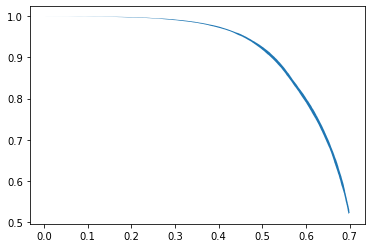

In [252]:
plot_pareto_with_std(
    x_mean=resampled_mean['flat_softmax']['info_recall'],
    x_std=resampled_std['flat_softmax']['info_recall'],
    y_mean=resampled_mean['flat_softmax']['correct'],
    y_std=resampled_std['flat_softmax']['correct'],
    num_std=1.96,
    # x_grid=np.linspace(0, 1, 101),
)

In [256]:
results.keys()

dict_keys([('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s0'), ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s1'), ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s2'), ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s3'), ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s4'), ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s0'), ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s1'), ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s2'), ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s3'), ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s4'), ('cond_multilabel', 'cond_multilabel-b64-lr0.01-wd0.0003-s0'), ('cond_multilabel', 'cond_multilabel-b64-lr0.01-wd0.0003-s1'), ('cond_multilabel', 'cond_multilabel-b64-lr0.01-wd0.0003-s2'), ('cond_multilabel', 'cond_multilabel-b64-lr0.01-wd0.0003-s3'), ('cond_multilabel', 'cond_multilabel-b64-lr0.01-wd0.0003-s4'), ('descendant_softmax', 'descendant_softmax-b64-lr0.01-wd0.0003-s0'), ('descendant_softmax', 'descendant_

In [544]:
def plot_metrics(x, y, tickres=None, save=False, xlim=None, ylim=None, figsize=(5, 4)):
    line_handles = []
    point_handles = []
    first_line = True
    plt.figure(figsize=figsize)

    for method_name in trials:
        method_trials = [
            trial_name for trial_name in trials[method_name]
            if (method_name, trial_name) in results
        ]
        # print('num trials:', len(method_trials))
        if not trial_names:
            continue

        # Plot errorbars.
        plot_pareto_with_std(
            x_mean=resampled_mean[method_name][x],
            y_mean=resampled_mean[method_name][y],
            x_std=resampled_std[method_name][x],
            y_std=resampled_std[method_name][y],
            alpha=0.333)

        ge = (score_grid >= 0.5)
        le = (score_grid <= 0.5)
        plt.plot(
            resampled_mean[method_name][x][le], resampled_mean[method_name][y][le],
            color=colors[method_name], linestyle='--')
        h = plt.plot(
            resampled_mean[method_name][x][ge], resampled_mean[method_name][y][ge],
            color=colors[method_name], label=method_titles.get(method_name, method_name))
        line_handles.extend(h)

        for inference_name in infer_fns:  # pred_metrics_mean[x][method_name].keys():
            h, = plt.plot(
                pred_metrics_mean[x][method_name][inference_name],
                pred_metrics_mean[y][method_name][inference_name],
                color=colors[method_name], linestyle='none',
                marker=markers[inference_name], markerfacecolor='none',
                label=inference_titles.get(inference_name, inference_name))
            if first_line:
                point_handles.append(h)
        first_line = False

    plt.grid('on')
    plt.xlabel(metric_titles.get(x, x))
    plt.ylabel(metric_titles.get(y, y))
    ax = plt.gca()

    if xlim:
        plt.xlim(**xlim)
    if ylim:
        plt.ylim(**ylim)
    # plt.ylim(np.clip(plt.ylim(), 0, 1))
    # plt.xlim(np.clip(plt.xlim(), 0, 1))
    if tickres:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tickres))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(tickres))
    # plt.axis('equal')
    # plt.gca().set_aspect(1)

    if save:
        pathlib.Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)
        plt.savefig(pathlib.Path(PLOT_DIR) / f'{x}-{y}.pdf')
        main_fig = plt.gcf()
        plt.figure(figsize=figsize)
        plt.legend(handles=[*line_handles, *point_handles], loc='center left')
        plt.axis('off')
        plt.savefig(pathlib.Path(PLOT_DIR) / f'{x}-{y}-legend.pdf')
        plt.close()
        plt.figure(main_fig.number)

    plt.legend(handles=[*line_handles, *point_handles], loc='lower left')
    plt.show()

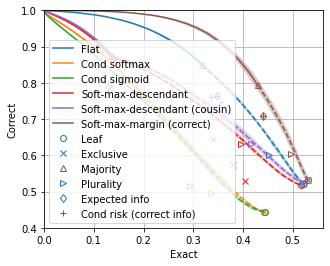

In [551]:
plot_metrics('exact', 'correct', tickres=0.1, xlim=dict(left=0), ylim=dict(top=1, bottom=0.4), save=True)

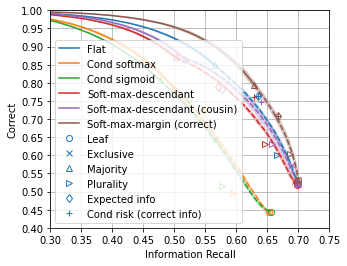

In [552]:
plot_metrics('info_recall', 'correct', tickres=0.05, xlim=dict(left=0.3, right=0.75), ylim=dict(bottom=0.4, top=1), save=True)

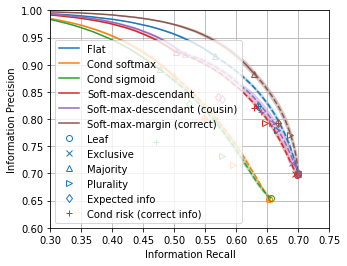

In [553]:
plot_metrics('info_recall', 'info_precision', tickres=0.05, xlim=dict(left=0.3, right=0.75), ylim=dict(bottom=0.6, top=1), save=True)

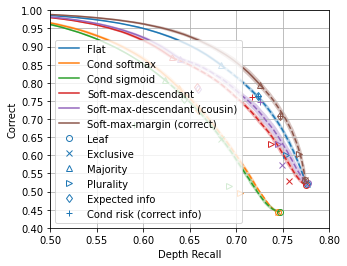

In [554]:
plot_metrics('depth_recall', 'correct', tickres=0.05, xlim=dict(left=0.5, right=0.8), ylim=dict(bottom=0.4, top=1), save=True)

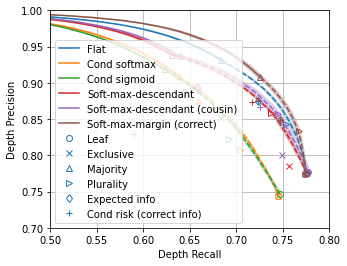

In [555]:
plot_metrics('depth_recall', 'depth_precision', tickres=0.05, xlim=dict(left=0.5, right=0.8), ylim=dict(bottom=0.7, top=1), save=True)